# HW3 Convolutional Neural Network

## Overview

In this homework, you will get introduced to CNN. More specifically, you will try CNN on X-Ray images.

---

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

# record start time
_START_RUNTIME = time.time()

# set seed
seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# Define data and weight path
DATA_PATH = "../HW3_CNN-lib/data"
WEIGHT_PATH = "../HW3_CNN-lib/resnet18_weights_9.pth"

In [2]:
DATA_PATH

'../HW3_CNN-lib/data'

---

## About Raw Data

Pneumonia is a lung disease characterized by inflammation of the airspaces in the lungs, most commonly due to an infection. In this section, you will train a CNN model to classify Pneumonia disease (Pneumonia/Normal) based on chest X-Ray images. 

The chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old. All chest X-ray imaging was performed as part of patients’ routine clinical care. You can refer to this [link](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5) for more information.

## 1 Load and Visualize the Data [20 points]

The data is under `DATA_PATH`. In this part, you are required to load the data into the data loader, and calculate some statistics.

In [3]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

#input
# folder: str, 'train', 'val', or 'test'
#output
# number_normal: number of normal samples in the given folder
# number_pneumonia: number of pneumonia samples in the given folder
def get_count_metrics(folder, data_path=DATA_PATH):
    
    '''
    TODO: Implement this function to return the number of normal and pneumonia samples.
          Hint: !ls $DATA_PATH
    '''
    
    normal_path = os.path.join(data_path, folder, 'NORMAL')
    pneumonia_path = os.path.join(data_path, folder, 'PNEUMONIA')
    
    number_normal = len(os.listdir(normal_path))
    number_pneumonia = len(os.listdir(pneumonia_path))
    
    return number_normal, number_pneumonia


#output
# train_loader: train data loader (type: torch.utils.data.DataLoader)
# val_loader: val data loader (type: torch.utils.data.DataLoader)
def load_data(data_path=DATA_PATH):
    
    '''
    TODO: Implement this function to return the data loader for 
    train and validation dataset. Set batchsize to 32.
    
    You should add the following transforms (https://pytorch.org/docs/stable/torchvision/transforms.html):
        1. transforms.RandomResizedCrop: the images should be cropped to 224 x 224
        2. transforms.ToTensor: just to convert data/labels to tensors
    You should set the *shuffle* flag for *train_loader* to be True, and False for *val_loader*.
    
    HINT: Consider using `torchvision.datasets.ImageFolder`.
    '''

    import torchvision
    import torchvision.datasets as datasets
    import torchvision.transforms as transforms

    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()
    ])
    
    train_dataset = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=transform)
    val_dataset = datasets.ImageFolder(os.path.join(data_path, 'val'), transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    return train_loader, val_loader
    

In [4]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

assert type(get_count_metrics('train')) is tuple
assert type(get_count_metrics('val')) is tuple

assert get_count_metrics('train') == (335, 387)
assert get_count_metrics('val') == (64, 104)



In [5]:
type(get_count_metrics('train'))

tuple

In [6]:
get_count_metrics('train')

(335, 387)

In [7]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

train_loader, val_loader = load_data()

assert type(train_loader) is torch.utils.data.dataloader.DataLoader

assert len(train_loader) == 23


In [8]:
type(train_loader), len(train_loader)

(torch.utils.data.dataloader.DataLoader, 23)

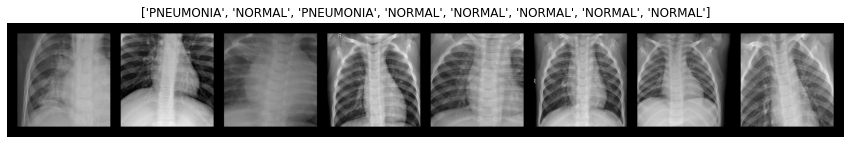

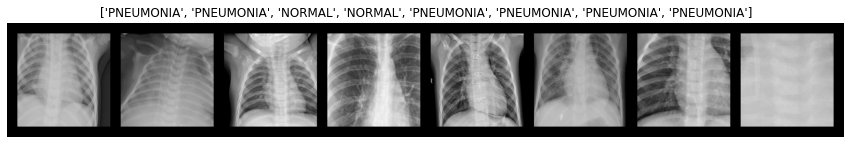

In [9]:
# DO NOT MODIFY THIS PART


import torchvision
import matplotlib.pyplot as plt

def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader, k=8):
    images, labels = next(iter(dataloader))
    images = images[:k]
    labels = labels[:k]
    img = torchvision.utils.make_grid(images, padding=25)
    imshow(img, title=["NORMAL" if x==0  else "PNEUMONIA" for x in labels])

train_loader, val_loader = load_data()   
for i in range(2):
    show_batch_images(train_loader)

## 2 Build the Model [35 points]

This time, you will define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you will use the following:
- [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
- [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most active pixels from the previous layer.
- The usual Linear + Dropout layers to avoid overfitting and produce a 2-dim output.

Below is a typical CNN architicture which consists of \[INPUT - CONV - RELU - POOL - FC\] layers.

<img src=./img/convnet.jpg>

### 2.1 Convolutional Layer Output Volume [10 points]
Before we get started, let us do a warm-up question.

Calculate the output volume for a convolutional layer: given the input volume size $W$, the kernel/filter size $F$, the stride $S$, and the amount of zero padding $P$ used on the border, calculate the output volume size.

In [10]:
def conv_output_volume(W, F, S, P):
    
    """
    TODO: Given the input volume size $W$, the kernel/filter size $F$, 
    the stride $S$, and the amount of zero padding $P$ used on the border, 
    calculate the output volume size.
    Note the output should a integer. 
    """
    
    output_volume = (W - F + 2 * P) // S + 1
    return output_volume

In [11]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

assert conv_output_volume(W=7, F=3, S=1, P=0) == 5
assert conv_output_volume(W=7, F=3, S=2, P=0) == 3
assert conv_output_volume(W=8, F=3, S=2, P=0) == 3



### 2.2 Define CNN [15 points]
Now, define your own CNN model below. Note that, the more convolutional layers you include, the more complex patterns the model can detect. For now, it is suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting.

It is also a good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at this [PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py).

Please do not use the same model structure as in Section 2.3. Specifically, let's define a small model with less than 10 layers/modules (must be fewer than 20). 

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=128 * 28 * 28, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        #input is of shape (batch_size=32, 3, 224, 224) if you did the dataloader right
        # Input shape: (batch_size, 3, 224, 224)
        x = self.pool(F.relu(self.conv1(x)))  # Output shape: (batch_size, 32, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))  # Output shape: (batch_size, 64, 56, 56)
        x = self.pool(F.relu(self.conv3(x)))  # Output shape: (batch_size, 128, 28, 28)
        
        # Flatten the output from the convolutional layers
        x = x.view(-1, 128 * 28 * 28)  # Output shape: (batch_size, 128 * 28 * 28)
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))  # Output shape: (batch_size, 512)
        x = self.dropout(x)
        x = self.fc2(x)  # Output shape: (batch_size, 2)
        
        return x

In [13]:
simple_model = SimpleCNN()
simple_model_size = sum([param.nelement() * param.element_size() for param in simple_model.parameters()]) / 1e9
print('SimpleCNN size in GB:', simple_model_size)
assert simple_model_size <= 1, 'SimpleCNN is too large! Please minimize the number of parameters.'

SimpleCNN size in GB: 0.20590004


In [14]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''
simple_model = SimpleCNN()

assert issubclass(type(simple_model), nn.Module), "Your CNN model should be a torch.nn.Module instance."
assert len(list(simple_model.modules())) < 20, "Your CNN model is too big. Please re-design."

test_input = torch.zeros(32, 3, 224, 224)
test_output = simple_model(test_input)
assert test_output.shape == torch.Size([32,2]), "Your CNN model has a wrong output size."



### 2.3 Using Predefined CNN Model [10 points]
In this section, we will import a predefined CNN, the ResNet18 model, which is pretty successful in many image classification tasks. We will modify the last layer to use it on our binary classification problem, but keep the rest of the structure the same

In [15]:
#output
# model: the cnn model
def get_cnn_model():
    
    """
    TODO: Define the CNN model here. 
        We will use a ResNet18 model. 
        For now, please set `pretrained=False`. We will manually load the weights later.
        Then, replace the last layer (model.fc) with a nn.Linear layer
            The new model.fc should have the same input size but a new output_size of 2
    """
    
    from torchvision import models
    
    num_classes = 2
    
    # Load the ResNet18 model
    model = models.resnet18(pretrained=False)
    
    # Get the number of input features for the last fully connected layer
    num_ftrs = model.fc.in_features
    
    # Replace the last fully connected layer with a new one for binary classification
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    #For computation efficiency, we will freeze the weights in the bottom layers
    for param in model.named_parameters():
        if param[0].split(".")[0] == 'fc':
            continue
        param[1].requires_grad = False
    return model

In [16]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

assert issubclass(type(get_cnn_model()), nn.Module), "Your CNN model should be a torch.nn.Module instance"
model = get_cnn_model()
assert len(list(model.modules())) == 68, "# of modules mismtach - Please use ResNet18"
assert len(list(model.parameters())) == 62, "# of parameter tensors mismtach - different model. Please use ResNet18"



## 3 Training the Network [25 points]

Due to the computation environment constraint, we will load some pre-trained weights instead of training everything from scratch. 

In [17]:
model = get_cnn_model()
#Load the pretrained weights
#If it fails, it probably means you did not define the model correctly
model.load_state_dict(torch.load(WEIGHT_PATH, map_location='cpu'))

<All keys matched successfully>

### 3.1 Criterion and Opimizer [10 points]
In this part, you will define the loss and optimizer for the model and then perform model training.

In [18]:
"""
TODO: Specify loss function (CrossEntropyLoss) and assign it to `criterion`.
Spcify optimizer (SGD) and assign it to `optimizer`.
Hint: the learning rate is usually a small number on the scale of 1e-4 ~ 1e-2
"""

import torch.optim as optim

# Specify the loss function (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# Specify the optimizer (SGD) with a learning rate of 0.001
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [19]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

assert isinstance(criterion, torch.nn.modules.loss.CrossEntropyLoss)
assert isinstance(optimizer, torch.optim.SGD)



### 3.2 Training [15 points]

Now let us train the CNN model we previously created.

Remember that from the previous HW, to train the model, you should follow the following step:
- Clear the gradients of all optimized variables
- Forward pass: compute predicted outputs by passing inputs to the model
- Calculate the loss
- Backward pass: compute gradient of the loss with respect to model parameters
- Perform a single optimization step (parameter update)
- Update average training loss


In [21]:
# number of epochs to train the model
# make sure your model finish training within 4 minutes on a CPU machine
# You can experiment different numbers for n_epochs, but even 1 epoch should be good enough.
n_epochs = 1

def train_model(model, train_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim
    """
    Train the CNN model.
    
    :param model: A CNN model
    :param train_dataloader: DataLoader for the training data
    :param n_epoch: Number of epochs to train
    :param optimizer: Optimizer for the model
    :param criterion: Loss function
    :return: Trained model
    """
    model.train() # prep model for training
    
    
    for epoch in range(n_epoch):
        curr_epoch_loss = []
        for data, target in train_dataloader:
            """
            TODO: Within the loop, do the normal training procedures:
                   pass the input through the model
                   pass the output through loss_func to compute the loss (name the variable as *loss*)
                   zero out currently accumulated gradient, use loss.basckward to backprop the gradients, then call optimizer.step
            """
            # Clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(data)
            
            # Calculate the loss
            loss = criterion(outputs, target)
            
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Perform a single optimization step (parameter update)
            optimizer.step()
            
            # Update average training loss
            curr_epoch_loss.append(loss.item())
            
            #curr_epoch_loss.append(loss.cpu().data.numpy())
        #print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
    return model

In [22]:
# get train and val data loader
train_loader, val_loader = load_data()

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model = train_model(model, train_loader)

## 4 Test the Trained Network [20 points]

In this step, you will test your model on the validation data and evaluate its performance.

In [25]:
def eval_model(model, dataloader):
    """
    :return:
        Y_pred: prediction of model on the dataloder.
            Should be an 2D numpy float array where the second dimension has length 2.
        Y_test: truth labels. Should be an numpy array of ints
    TODO:
        evaluate the model using on the data in the dataloder.
        Add all the prediction and truth to the corresponding list
        Convert Y_pred and Y_test to numpy arrays (of shape (n_data_points, 2))
    """
    model.eval()
    Y_pred = []
    Y_test = []
#     for data, target in dataloader:
#         # your code here
#         raise NotImplementedError
#     Y_pred = np.concatenate(Y_pred, axis=0)
#     Y_test = np.concatenate(Y_test, axis=0)

    with torch.no_grad():  # Disable gradient computation
        for data, target in dataloader:
            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(data)
            
            # Convert outputs to class predictions
            _, predicted = torch.max(outputs, 1)
            
            # Append the predictions and the true labels to the lists
            Y_pred.append(predicted.cpu().numpy())
            Y_test.append(target.cpu().numpy())
    
    # Convert lists to numpy arrays
    Y_pred = np.concatenate(Y_pred, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)

    return Y_pred, Y_test

In [26]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''
from sklearn.metrics import accuracy_score

y_pred, y_true = eval_model(model, val_loader)
acc = accuracy_score(y_true, y_pred)
print(("Validation Accuracy: " + str(acc)))
assert acc > 0.7, "Validation Accuracy below 0.7 for validation data!"
assert len(y_true) == len(y_pred) == 168, "Output size is wrong"



Validation Accuracy: 0.8690476190476191


In [27]:
#As noted before, please make sure the whole notebook does not exceed 4 mins on a CPU
print("Total running time = {:.2f} seconds".format(time.time() - _START_RUNTIME))

Total running time = 462.63 seconds
